In [1]:
import sys
sys.path.append('..')
import datetime
import holidays
import math
import polars as pl
from typing import *
from sklearn.metrics.pairwise import haversine_distances
import matplotlib.pyplot as plt
import numpy as np
from src.utils import read_all_csvs
from mlxtend.evaluate import GroupTimeSeriesSplit
from src.feature_engineering import GetWeatherFeaturesForPeriod
from xgboost import XGBRegressor
from src.evaluation import TimeSeriesCrossValidationExecutor
from sklearn.metrics import r2_score, mean_absolute_error
from src.simulation import WalkForwardSimulationRunner

In [2]:
TUNING = True

In [3]:
def mean_coords_from_start_end(
    df: pl.DataFrame,
    start_id_col: str = "start_station_id",
    start_lat_col: str = "start_lat",
    start_lon_col: str = "start_lng",
    end_id_col: str = "end_station_id",
    end_lat_col: str = "end_lat",
    end_lon_col: str = "end_lng",
) -> Dict[Any, Union[Tuple[float, float], Dict[str, float]]]:

    start = df.select([
        pl.col(start_id_col).alias("id"),
        pl.col(start_lat_col).cast(pl.Float64).alias("lat"),
        pl.col(start_lon_col).cast(pl.Float64).alias("lon")
    ])

    end = df.select([
        pl.col(end_id_col).alias("id"),
        pl.col(end_lat_col).cast(pl.Float64).alias("lat"),
        pl.col(end_lon_col).cast(pl.Float64).alias("lon")
    ])

    stacked = pl.concat([start, end], how="vertical")

    stacked = stacked.filter(pl.col("id").is_not_null() & pl.col("lat").is_not_null() & pl.col("lon").is_not_null())

    agg = (
        stacked
        .group_by("id", maintain_order=True)
        .agg([
            pl.col("lat").sum().alias("sum_lat"),
            pl.col("lon").sum().alias("sum_lon"), 
            pl.count().alias("sum")
        ])
        .with_columns([
            (pl.col("sum_lat") / pl.col("sum")).alias("mean_lat"),
            (pl.col("sum_lon") / pl.col("sum")).alias("mean_lon")
        ])
        .select(["id", "mean_lat", "mean_lon"])
    )

    out = {}
    for id_val, mlat, mlon in agg.iter_rows():
        out[id_val] = {"lat": float(mlat), "lon": float(mlon)}
    return out


In [4]:
from typing import Dict, Tuple


def feature_engineering(df : pl.DataFrame, station_dict : Dict[float, Tuple[float]], additional_shift : int = 24) -> pl.DataFrame:

    df = df.with_columns(
        pl.col("station_id").map_elements(lambda x: station_dict.get(x, {'lat' : None})['lat']).alias("rough_station_lat"),
        pl.col("station_id").map_elements(lambda x: station_dict.get(x, {'lon' : None})['lon']).alias("rough_station_lng"),
        pl.col("net_flow").shift(12 + additional_shift).over("station_id").fill_null(-1).alias("net_lag_halfday"),
        pl.col("net_flow").shift(24 + additional_shift).over("station_id").fill_null(-1).alias("net_lag_day"),
        pl.col("net_flow").shift(24*7 + additional_shift).over("station_id").fill_null(-1).alias("net_lag_week"),
        (pl.col("snow").fill_null(-1) > 0).cast(bool).alias("snowed?"),
        pl.col("bucket").dt.hour().alias("hour_of_day"),
        pl.col("bucket").dt.is_business_day(holidays=holidays.country_holidays('US', subdiv='NY')).alias("working_day?"),
        pl.col("bucket").dt.weekday().alias("day_of_week"),
        pl.col("bucket").dt.date().alias("group"),
        (pl.col("bucket").dt.hour() < 6).alias("night"),
        pl.col("net_flow").shift(additional_shift).rolling_mean(window_size=6).fill_null(0).over("station_id").alias("roll_mean_6h"),
        pl.col("net_flow").shift(additional_shift).rolling_mean(window_size=12).fill_null(0).over("station_id").alias("roll_mean_12h"),
        pl.col("net_flow").shift(additional_shift).rolling_mean(window_size=24).fill_null(0).over("station_id").alias("roll_mean_24h"),
        pl.col("net_flow").shift(additional_shift).rolling_mean(window_size=24*7).fill_null(0).over("station_id").alias("roll_mean_week"),
    )

    return df

In [5]:
def process_data(df : pl.DataFrame):
    """
    Adding useful columns derived from existing raw data
    """
    
    df = df.with_columns(
        pl.col("started_at").str.strptime(pl.Datetime).alias("started_at"),
        pl.col("ended_at").str.strptime(pl.Datetime).alias("ended_at"),
    )
    
    df = df.with_columns(
        (pl.col("ended_at") - pl.col("started_at")).dt.total_seconds().alias("ride_duration_seconds"),
        (pl.col("ended_at") - pl.col("started_at")).dt.total_hours().alias("ride_duration_hours"),
        pl.col("started_at").dt.hour().alias("start_hour"),
        pl.col("started_at").dt.day().alias("start_day"),
        pl.col("started_at").dt.month().alias("start_month"),
        pl.col("started_at").dt.weekday().alias("start_weekday"),
    )

    kms = []
    for row in df.iter_rows(named=True):
        try:
            a_rad = [math.radians(row["start_lat"]), math.radians(row["start_lng"])]
            b_rad = [math.radians(row["end_lat"]), math.radians(row["end_lng"])]
            dist_km = haversine_distances([a_rad, b_rad]) * 6371
            kms += [dist_km[0][1]]
        except Exception as e:
            kms += [None]
    df = df.with_columns(pl.Series(kms).alias("ride_distance_km"))
    df = df.with_columns((pl.col("ride_distance_km") * 3600 / pl.col("ride_duration_seconds")).alias("ride_speed_kmh"))
    return df

In [6]:
def plot_routes(data : pl.DataFrame):
    plt.figure(figsize=(10, 10))
    
    for row in data.iter_rows(named=True):
        start_x = row.get("start_lat")
        start_y = row.get("start_lng")
        end_x = row.get("end_lat")
        end_y = row.get("end_lng")

        plt.plot([start_x, end_x], [start_y, end_y], marker='o', markersize=2, color='#1f77b4', alpha=0.7, linewidth=1)

    plt.title("Bike Routes")
    plt.xlabel("Latitude")
    plt.ylabel("Longitude")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

In [7]:
def plot_cumulative_bike_plot(df : pl.DataFrame, station_name : str):
    start_col_name = "start_station_name"
    end_col_name = "end_station_name"

    outbounds = (df[start_col_name] == station_name).cast(int)
    inbounds = (df[end_col_name] == station_name).cast(int)

    change = inbounds - outbounds

    number_of_bikes_at_station  = np.cumsum(change.fill_null(0).to_numpy())

    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(number_of_bikes_at_station.shape[0]), number_of_bikes_at_station, label="Number of bikes at station")
    plt.show()

In [8]:
plot_df = pl.read_csv('../data/202501-citibike-tripdata_1.csv', ignore_errors=True)
plot_df = process_data(plot_df)

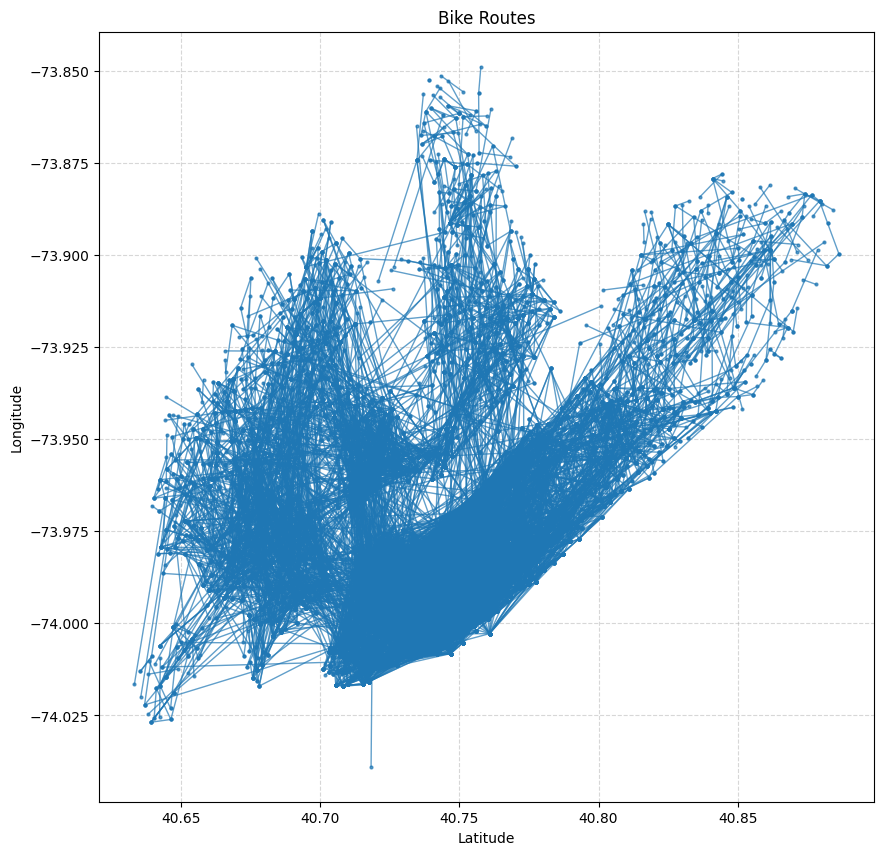

In [9]:
plot_routes(plot_df.sample(10000))

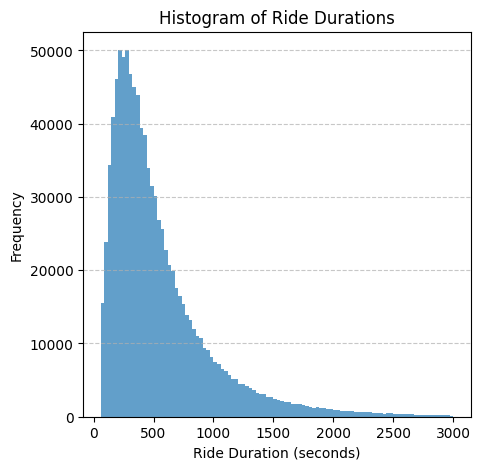

In [10]:
plt.figure(figsize=(5,5))
plt.hist(plot_df.filter(pl.col("ride_duration_seconds") < 3000)['ride_duration_seconds'], bins=100, color='#1f77b4', alpha=0.7)
plt.title('Histogram of Ride Durations')
plt.xlabel('Ride Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

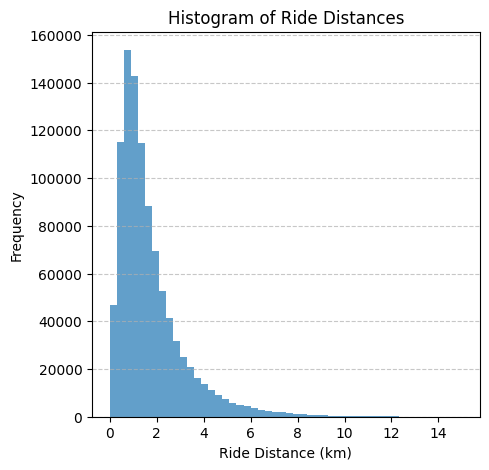

In [11]:
plt.figure(figsize=(5, 5))

filtered_distances = plot_df.filter(pl.col('ride_distance_km') <= 15).drop_nulls()['ride_distance_km']

plt.hist(filtered_distances, bins=50, color='#1f77b4', alpha=0.7)

plt.title('Histogram of Ride Distances')
plt.xlabel('Ride Distance (km)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [13]:
from src.preprocessing import NetFlowBinner


bucket_interval = "1h"
df = read_all_csvs('../data')

binner = NetFlowBinner(
    df,
    bucket_interval
)

full_station_time_buckets = binner.process()

In [14]:
start = full_station_time_buckets['bucket'].min()
stop = full_station_time_buckets['bucket'].max()

all_features = GetWeatherFeaturesForPeriod(
    start,
    stop
).add_weather_features(full_station_time_buckets)


station_dict = mean_coords_from_start_end(df)
all_features = feature_engineering(all_features, station_dict, additional_shift=7*24)
all_features = all_features.sort(by='group')

(Deprecated in version 0.20.5)

A later expression might fail because the output type is not known. Set return_dtype=pl.self_dtype() if the type is unchanged, or set the proper output data type.


In [15]:
train_set, test_set = all_features.filter(pl.col("bucket") < datetime.datetime(2025, 2, 1)), all_features.filter(pl.col("bucket") >= datetime.datetime(2025, 2, 1))

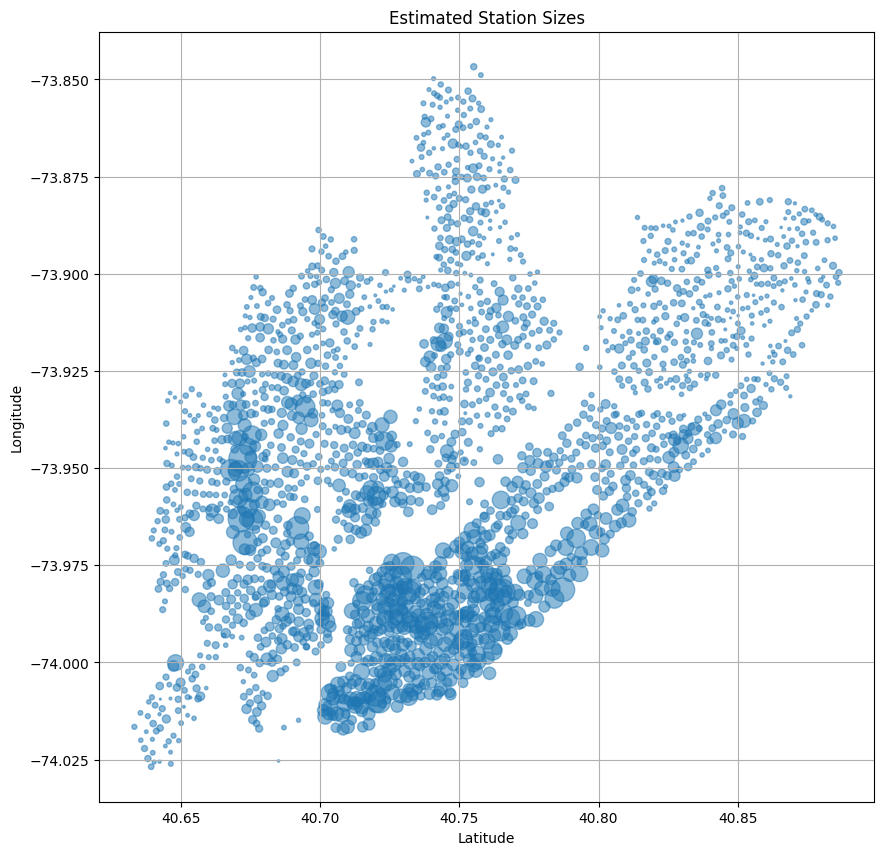

In [16]:
from src.feature_engineering import bike_station_optimisation_metrics


station_metrics = bike_station_optimisation_metrics(train_set)
station_metrics = station_metrics.group_by("station_id").first()

plt.figure(figsize=(10, 10))
plt.scatter(
    station_metrics["rough_station_lat"],
    station_metrics["rough_station_lng"],
    s=station_metrics["estimated_station_size"],
    alpha=0.5
)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Estimated Station Sizes")
plt.grid(True)

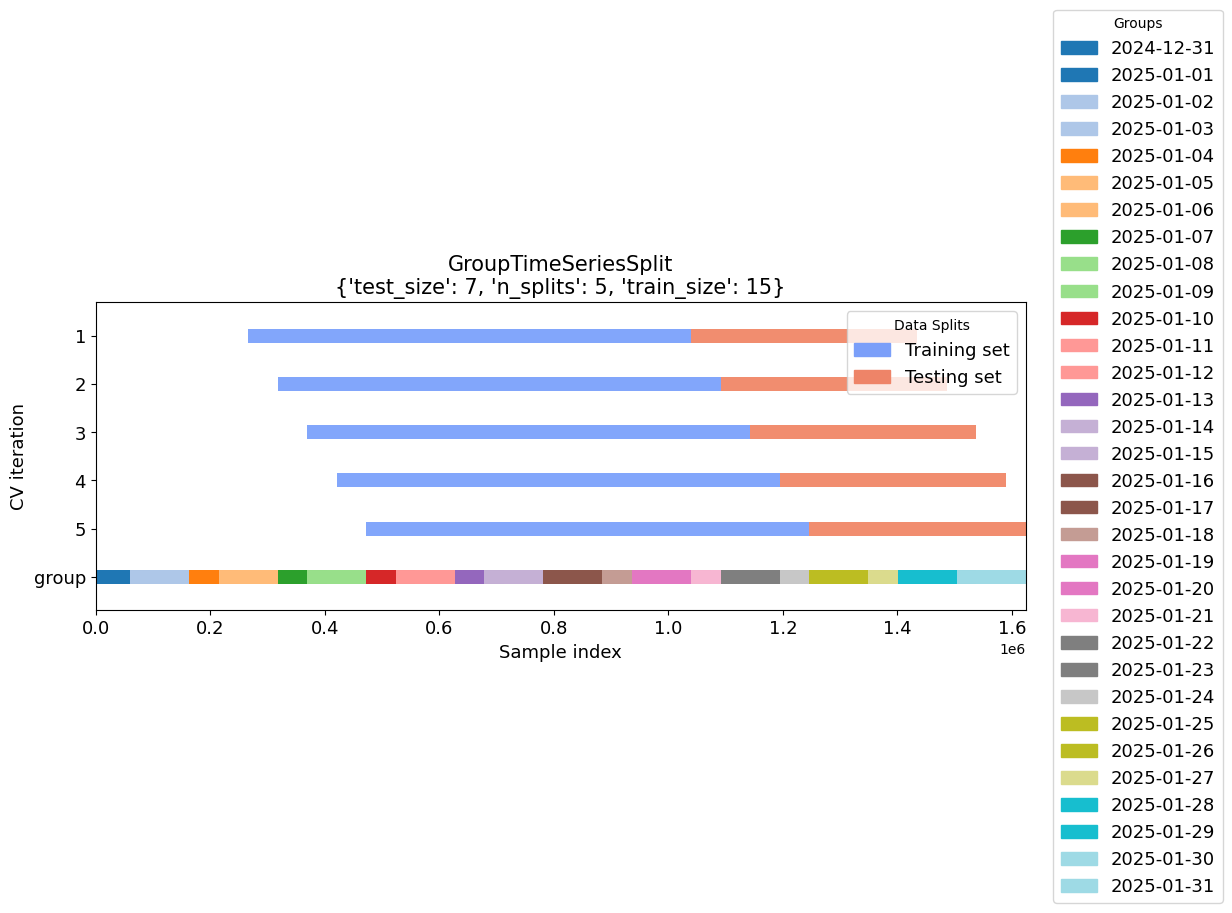

In [32]:
features = [
    "temp",
    "rhum",
    # "prcp",
    "wspd",
    "net_lag_halfday",
    "net_lag_day",
    "net_lag_week",
    "hour_of_day",
    "working_day?",
    "day_of_week",
    "night",
    "rough_station_lat",
    "rough_station_lng",
    "roll_mean_6h",
    "roll_mean_12h",
    "roll_mean_24h",
    "roll_mean_week"
]

target = "net_flow"

cv_args = {"test_size": 7, "n_splits": 5, "train_size" : 15}
all_features = all_features.sort("bucket")

from mlxtend.evaluate.time_series import plot_splits
plot_splits(train_set, train_set, train_set['group'], **cv_args)

In [33]:
model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

X, y = train_set[features], train_set[target]
noise1 = pl.Series("noise1", np.random.randn(X.height))
noise2 = pl.Series("noise2", np.random.randn(X.height))
X = X.with_columns([noise1, noise2])

model.fit(X, y)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


<Figure size 1000x800 with 0 Axes>

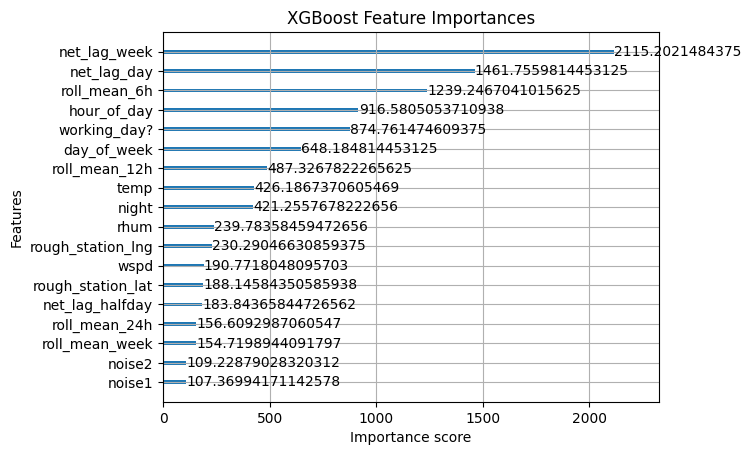

In [34]:
from xgboost import plot_importance

plt.figure(figsize=(10, 8))
plot_importance(model, importance_type='gain', max_num_features=20)
plt.title('XGBoost Feature Importances')
plt.show()

In [ ]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error


splitter = GroupTimeSeriesSplit(**cv_args)


if TUNING:
    def objective(trial : optuna.Trial):
        params = {
            'objective': 'reg:squarederror',
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  
            'gamma': trial.suggest_float('gamma', 0, 5),  
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),  
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),  
            'random_state': 42,
            'n_jobs': -1
        }   

        model = XGBRegressor(**params)

        exec = TimeSeriesCrossValidationExecutor(
            train_set,
            features,
            target,
            "group",
            splitter,
            model,
            metrics=[mean_absolute_error]
        )

        _, oof, results = exec.run()
        
        return np.mean(results[mean_absolute_error.__name__])
                
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30)

    print("Best parameters found: ", study.best_params)

In [42]:
tuned_params = {'objective' : "reg:squarederror", 'random_state' : 42, 'n_jobs' : -1, 'n_estimators': 206, 'learning_rate': 0.012054699406099687, 'max_depth': 6, 'min_child_weight': 4, 'gamma': 2.775380403601382, 'subsample': 0.913748310952994, 'colsample_bytree': 0.891198776590767, 'colsample_bylevel': 0.8522433217041232, 'scale_pos_weight': 1.0091294624440992}
tuned_model = XGBRegressor(**tuned_params)

In [43]:
cv_args = {"test_size": 7, "n_splits": 10, "train_size" : 15}
splitter = GroupTimeSeriesSplit(**cv_args)

exec = TimeSeriesCrossValidationExecutor(
    train_set,
    features,
    target,
    "group",
    splitter,
    tuned_model,
    save_folder="./data/xgb_fold_models",
    metrics=[r2_score, mean_absolute_error]
)

model, oof, _ = exec.run()

Fold 1 results:
r2_score: 0.227 mean_absolute_error: 0.867 
Fold 2 results:
r2_score: 0.210 mean_absolute_error: 0.845 
Fold 3 results:
r2_score: 0.211 mean_absolute_error: 0.823 
Fold 4 results:
r2_score: 0.208 mean_absolute_error: 0.821 
Fold 5 results:
r2_score: 0.203 mean_absolute_error: 0.843 
Fold 6 results:
r2_score: 0.217 mean_absolute_error: 0.892 
Fold 7 results:
r2_score: 0.212 mean_absolute_error: 0.945 
Fold 8 results:
r2_score: 0.222 mean_absolute_error: 0.990 
Fold 9 results:
r2_score: 0.232 mean_absolute_error: 1.021 
Fold 10 results:
r2_score: 0.225 mean_absolute_error: 1.023 
Average r2_score across folds: 0.2167212188243866
Average mean_absolute_error across folds: 0.9068891704082489


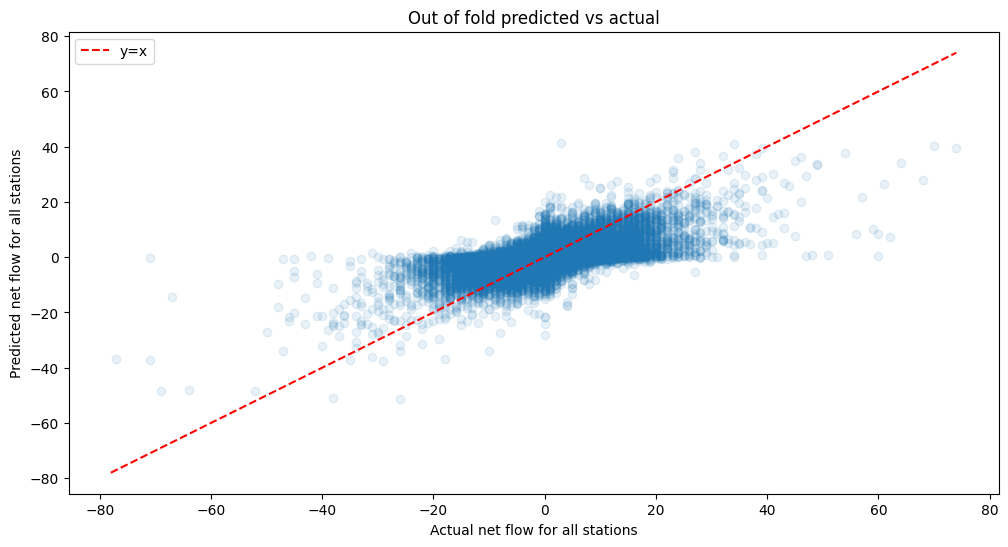

In [44]:
y = train_set[target]
plt.figure(figsize=(12, 6))
plt.scatter(y, oof, alpha=0.1)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="y=x")
plt.xlabel("Actual net flow for all stations")
plt.ylabel("Predicted net flow for all stations")
plt.title("Out of fold predicted vs actual")
plt.legend()
plt.show()

In [45]:
all_features = feature_engineering(all_features, station_dict, additional_shift=7*24)
train_set, test_set = all_features.filter(pl.col("bucket") < datetime.datetime(2025, 2, 1)), all_features.filter(pl.col("bucket") >= datetime.datetime(2025, 2, 1))

simulator = WalkForwardSimulationRunner(
    train_data=train_set,
    test_data=test_set,
    model=tuned_model,
    training_col_names=features,
    target=target,
    plot_save_path="./data/plots"
)

simulator.run()


A later expression might fail because the output type is not known. Set return_dtype=pl.self_dtype() if the type is unchanged, or set the proper output data type.


Train interval is: 2025-01-02 to 2025-01-31
Test interval is: 2025-02-01 to 2025-02-07
Number of bikes that need to be moved (ML): 1811
Number of bikes that need to be moved (average method): 17133
Stockouts without adjustment: 451, with ML adjustment: 430, with mean adjustment: 320
Stockout reduction / bikes moved ratio (ML): 0.011595803423522915, (Mean): 0.00764606315297963
Train interval is: 2025-01-09 to 2025-02-07
Test interval is: 2025-02-08 to 2025-02-14
Number of bikes that need to be moved (ML): 5181
Number of bikes that need to be moved (average method): 20082
Stockouts without adjustment: 501, with ML adjustment: 417, with mean adjustment: 278
Stockout reduction / bikes moved ratio (ML): 0.016213086276780544, (Mean): 0.011104471666168708
Train interval is: 2025-01-16 to 2025-02-14
Test interval is: 2025-02-15 to 2025-02-21
Number of bikes that need to be moved (ML): 8259
Number of bikes that need to be moved (average method): 23016
Stockouts without adjustment: 520, with ML 